# Imports

In [3]:
import pandas as pd
import pickle
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.models.ldamodel import LdaModel
from gensim import models, similarities
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
import sampling
import numpy as np
import mglearn
from gensim.corpora import Dictionary
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models.coherencemodel import CoherenceModel

pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt

from lda_training import train_lda_model
from lda_training import get_topics_vector_for_doc
from lda_training import get_top_topics_for_doc
from lda_training import get_topic_words_dict
from lda_training import create_doc_per_topic_dict
from lda_training import create_topic_per_doc_dict

%matplotlib inline

# Constants

## Load:

In [ ]:
ING_CLEAN_NO_COMMON = '../Data/cleaned_files/ingredients_clean_without_common_words.obj'
KEYWORDS_CLEAN = '../Data/cleaned_files/keywords_cleaned.obj'
CATEGORIES_CLEAN = '../Data/cleaned_files/categories_cleaned.obj'
NAMES_CLEAN = '../Data/cleaned_files/names_cleaned.obj'

RECIPES_BASE = "../Data/base/recipes_base.parquet"
RECIPES_DESCRIPTIVE = "../Data/base/recipes_descriptive.parquet"
RATINGS_BASE = "../Data/base/ratings_base.parquet"

INDEX_TO_RECIPE_OBJ = "../Data/index/index_to_recipe.obj"
RECIPE_TO_INDEX_OBJ = "../Data/index/recipe_to_index.obj"
RECIPE_ID_TO_NAME_OBJ = "../Data/index/recipe_id_to_name.obj"
RECIPE_ID_TO_CAT = "../Data/index/recipe_id_to_category.obj"

CONCATENATED_ING_CAT_DF = "../Data/samples/concatenated_ing_cat_df.obj"
CONCATENATED_ING_CAT_KEY_DF = "../Data/samples/concatenated_ing_cat_key_df.obj"

## Save:

In [2]:
LDA_MODEL_ING_MIN_20 = "../Data/LDA/lda_model_ing_both_min_20.obj"
DICTIONARY_ING_MIN_20 = "../Data/LDA/dictionary_ing_both_min_20.obj"
CORPUS_ING_MIN_20 = "../Data/corpus_ing_both_min_20.obj"

LDA_MODEL_ING_CAT_MIN_20 = "../Data/LDA/lda_model_ing_cat_both_min_20.obj"
DICTIONARY_ING_CAT_MIN_20 = "../Data/LDA/dictionary_ing_cat_both_min_20.obj"
CORPUS_ING_CAT_MIN_20 = "../Data/LDA/corpus_ing_cat_both_min_20.obj"

# Load data

In [5]:
recipes_base = pd.read_parquet(RECIPES_BASE)
recipes_desc = pd.read_parquet(RECIPES_DESCRIPTIVE)
ratings_base = pd.read_parquet(RATINGS_BASE)

with open(ING_CLEAN_NO_COMMON, "rb") as input_file:
    ingredients_no_common_words = pickle.load(input_file)

with open(KEYWORDS_CLEAN, "rb") as input_file:
    keywords_clean = pickle.load(input_file)

with open(CATEGORIES_CLEAN, "rb") as input_file:
    categories_clean = pickle.load(input_file)
    
with open(NAMES_CLEAN, "rb") as input_file:
    names_clean = pickle.load(input_file)
    
with open(INDEX_TO_RECIPE_OBJ, "rb") as input_file:
    index_to_recipe = pickle.load(input_file)

with open(RECIPE_TO_INDEX_OBJ, "rb") as input_file:
    recipe_to_index = pickle.load(input_file)
    
with open(RECIPE_ID_TO_NAME_OBJ, "rb") as input_file:
    recipe_id_to_name = pickle.load(input_file)
    
with open(RECIPE_ID_TO_CAT, "rb") as input_file:
    recipe_id_to_cat = pickle.load(input_file)

with open(CONCATENATED_ING_CAT_DF, "rb") as input_file:
    concatenated_ing_cat = pickle.load(input_file)
    
with open(CONCATENATED_ING_CAT_KEY_DF, "rb") as input_file:
    concatenated_ing_cat_key = pickle.load(input_file)
    


## Samples

In [6]:
author_min_20 = sampling.get_rating_with_min_number(ratings_desc, 20, col_name='AuthorId')
recipe_min_20 = sampling.get_rating_with_min_number(ratings_desc, 20, col_name='RecipeId')

In [7]:
ratings_min_20 = sampling.get_ratings_with_min_number_list(ratings_desc, [20,20])

## Ratings where each user have min 20 ratings

In [8]:
print('Number of ratings: ', author_min_20.shape[0])
print('Number of users: ', author_min_20.AuthorId.nunique())
print('Number of recipes: ', author_min_20.RecipeId.nunique())

Number of ratings:  907573
Number of users:  7841
Number of recipes:  234111


In [9]:
ids_author_min_20 = list(set(author_min_20.RecipeId))
recipes_author_min_20 = recipes_small[recipes_small.RecipeId.isin(ids_author_min_20)]

## Ratings where each recipe have min 20 ratings

In [10]:
print('Number of ratings: ', recipe_min_20.shape[0])
print('Number of users: ', recipe_min_20.AuthorId.nunique())
print('Number of recipes: ', recipe_min_20.RecipeId.nunique())

Number of ratings:  552460
Number of users:  156783
Number of recipes:  9607


In [11]:
ids_recipe_min_20 = list(set(recipe_min_20.RecipeId))
recipes_recipe_min_20 = recipes_small[recipes_small.RecipeId.isin(ids_recipe_min_20)]

## Ratings where each user and recipe have min 20 ratings

In [12]:
print('Number of ratings: ', ratings_min_20.shape[0])
print('Number of users: ', ratings_min_20.AuthorId.nunique())
print('Number of recipes: ', ratings_min_20.RecipeId.nunique())

Number of ratings:  310022
Number of users:  7828
Number of recipes:  9578


In [13]:
ids_both_min_20 = list(set(ratings_min_20.RecipeId))
recipes_both_min_20 = recipes_small[recipes_small.RecipeId.isin(ids_both_min_20)]

## Sampled lists

In [15]:
concatenated_ing_cat_both_min_20 = concatenated_ing_cat[concatenated_ing_cat.RecipeId.isin(ids_both_min_20)]

In [16]:
ingredients_both_min_20 = ingredients_no_common_words[ingredients_no_common_words.RecipeId.isin(ids_both_min_20)]

In [17]:
ids_ingredients_both_min_20 = ingredients_both_min_20['RecipeId']
ingredients_lists_both_min_20 = ingredients_both_min_20['Ingredients']

In [18]:
ids_concatenated_both_min_20 = concatenated_ing_cat['RecipeId']
concatenated_ing_cat_lists_both_min_20 = concatenated_ing_cat['Concatenated']

# LDA

## Best number of topics for INGREDIENTS

In [36]:
start=20; limit=100; step=1
model_list, coherence_values = compute_coherence_values(ingredients_lists_both_min_20, start=start, limit=limit, step=step)

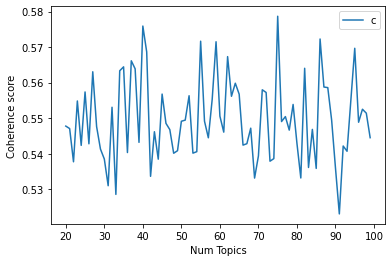

In [39]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [48]:
arr = np.array(coherence_values)
argmax = np.argmax(arr)
num_of_topics = range(start, limit, step)
num_topics_ingredients = num_of_topics[argmax]

75

## Best number of topics for INGREDIENTS, KEYWORDS

In [71]:
model_list, coherence_values = compute_coherence_values(concatenated_ing_cat, start=start, limit=limit, step=step)

Wall time: 7h 25min 49s


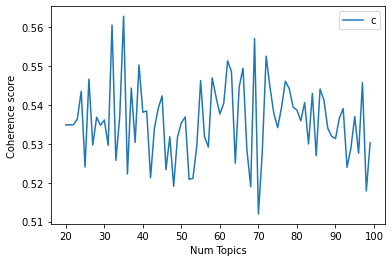

In [72]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [73]:
arr = np.array(coherence_values)
arg = np.argmax(arr)
max_coh = np.max(arr)

num_of_topics = range(start, limit, step)
num_topics_concatenated = num_of_topics[arg]

35

## Ingredients

In [18]:
num_topics_ingredients = num_topics_ingredients
passes = 50

### Training

In [84]:
%%time
dictionary_ing, corpus_ing, lda_model_ing = train_lda_model(ingredients_lists_both_min_20, num_topics_ingredients, passes)

Wall time: 3min 30s


### Dicitionaries

In [85]:
words_per_topic_dict = get_topic_words_dict(lda_model_ing, num_topics_ingredients, 10)

In [86]:
topics_per_doc_dict = create_topic_per_doc_dict(lda_model_ing, corpus_ing, ids_ingredients_both_min_20, n=2)

In [87]:
docs_per_topic_dict = create_doc_per_topic_dict(topics_per_doc_dict, ids_ingredients_both_min_20, n=20)

### Visualisations

In [1]:
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim_models.prepare(lda_model_ing, corpus_ing, dictionary_ing)
# vis

In [89]:
recipe_id = list(ids_ingredients_both_min_20)[200]
print("Ingredients for document", recipe_id, ingredients_lists_both_min_20[recipe_to_index[recipe_id]])

Ingredients for document 4573 ['butter', 'sugar', 'vanilla extract']


In [90]:
top_topics = topics_per_doc_dict[recipe_id]
print("Top topics for document:", top_topics)

Top topics for document: [11, 22]


In [91]:
for topic in top_topics:
    print("Words for topic", topic, words_per_topic_dict[topic][:5])

Words for topic 11 ['cream cheese', 'granulate sugar', 'vanilla extract', 'butter', 'powdered sugar']
Words for topic 22 ['purpose flour', 'sugar', 'egg', 'powder', 'unsalted butter']


### Save model

In [99]:
# with open(LDA_MODEL_ING_MIN_20, 'wb') as pickle_file:
#     pickle.dump(lda_model_ing, pickle_file)
    
# with open(DICTIONARY_ING_MIN_20, 'wb') as pickle_file:
#     pickle.dump(dictionary_ing, pickle_file)
    
# with open(CORPUS_ING_MIN_20, 'wb') as pickle_file:
#     pickle.dump(corpus_ing, pickle_file)

## Ingredients & categories

In [103]:
num_topics_ing_cat = 35
passes = 50

### Training

In [104]:
%%time
dictionary_ing_cat, corpus_ing_cat, lda_model_ing_cat = train_lda_model(concatenated_ing_cat_lists_both_min_20, 
                                                                        num_topics_ing_cat, 
                                                                        passes)

Wall time: 2h 51min 15s


### Dictionaries

In [105]:
words_per_topic_dict = get_topic_words_dict(lda_model_ing_cat, num_topics_ing_cat, 10)

topics_per_doc_dict = create_topic_per_doc_dict(lda_model_ing_cat, corpus_ing_cat, ids_concatenated_both_min_20, n=2)

docs_per_topic_dict = create_doc_per_topic_dict(topics_per_doc_dict, ids_concatenated_both_min_20, n=20)

In [110]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_ing_cat, corpus_ing_cat, dictionary_ing_cat)
vis

C:\anaconda\envs\RecSys\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
30    -0.306719  0.144716       1        1  7.143247
4      0.267417  0.077162       2        1  6.496598
7      0.245404  0.108293       3        1  5.513346
21    -0.258746  0.170928       4        1  4.656873
18    -0.258105  0.081395       5        1  4.151730
16     0.286316  0.041208       6        1  4.127961
33     0.265854  0.035693       7        1  3.921803
17    -0.072743 -0.173004       8        1  3.424962
9      0.142686 -0.046740       9        1  3.299200
13     0.169204  0.136935      10        1  3.071710
11     0.231547  0.053598      11        1  3.015269
24     0.081845 -0.116663      12        1  3.002459
19     0.098806  0.189246      13        1  2.883222
34     0.040385  0.128785      14        1  2.878285
1      0.098854  0.065827      15        1  2.849508
6     -0.084620  0.246423      16        1  2.797339
32     0.065679 -0.095822      17        1  2.648970
29     0.159618 -0.024056      18        1  2.634924
8     -0.215874  0.203673      19        1  2.572863
27    -0.076048 -0.136778      20        1  2.545287
2     -0.152741 -0.113060      21        1  2.420181
20     0.117053 -0.080187      22        1  2.316519
5     -0.091458 -0.143575      23        1  2.098517
10    -0.222756  0.136664      24        1  1.977202
12    -0.012175  0.013036      25        1  1.959735
25    -0.069885 -0.132901      26        1  1.936031
28    -0.104938 -0.164662      27        1  1.931706
31     0.096123  0.097498      28        1  1.811067
22    -0.047510 -0.153056      29        1  1.739050
23    -0.172430  0.093501      30        1  1.602546
0     -0.035939 -0.152579      31        1  1.572342
14    -0.037804 -0.167583      32        1  1.379643
3      0.031189 -0.105435      33        1  1.349054
26    -0.102733 -0.034230      34        1  1.171405
15    -0.074757 -0.184249      35        1  1.099448, topic_info=                            Term           Freq          Total Category  \
31                         water  104191.000000  104191.000000  Default   
14                           egg  127525.000000  127525.000000  Default   
41                     olive oil   89338.000000   89338.000000  Default   
3                    lemon juice   43129.000000   43129.000000  Default   
181                       potato   33722.000000   33722.000000  Default   
...                          ...            ...            ...      ...   
743        sweet unsalted butter     132.340516     133.362647  Topic35   
682               cherry gelatin     103.852365     104.874495  Topic35   
1206    french vanilla ice cream      97.230361      98.252491  Topic35   
560   fat free mozzarella cheese      96.557423      97.579554  Topic35   
30                         sugar    2669.808188  116823.198364  Topic35   

      logprob  loglift  
31    30.0000  30.0000  
14    29.0000  29.0000  
41    28.0000  28.0000  
3     27.0000  27.0000  
181   26.0000  26.0000  
...       ...      ...  
743   -5.9099   4.5027  
682   -6.1523   4.5006  
1206  -6.2182   4.4999  
560   -6.2251   4.4998  
30    -2.9055   0.7317  

[1328 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
797      12  0.790053       15min
797      14  0.209806       15min
317      27  0.999947       30min
1050      3  0.999910       4hour
124      25  0.999927       60min
...     ...       ...         ...
828      11  0.998135  ziti pasta
45        2  0.721079    zucchini
45        3  0.152281    zucchini
45        6  0.057402    zucchini
45       21  0.069167    zucchini

[1226 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[31, 5, 8, 22, 19, 17, 34, 18, 10, 14, 12, 25, 20, 35, 2, 7, 33, 30, 9, 28, 3, 21, 6, 11, 13, 26, 29, 32, 23, 24, 1, 15, 4, 27, 16])

In [107]:
recipe_id = list(ids_ingredients_both_min_20)[200]
print("Ingredients for document", recipe_id, ingredients_lists_both_min_20[recipe_to_index[recipe_id]])

top_topics = topics_per_doc_dict[recipe_id]
print("Top topics for document:", top_topics)

for topic in top_topics:
    print("Words for topic", topic, words_per_topic_dict[topic][:5])

Ingredients for document 4573 ['butter', 'sugar', 'vanilla extract']
Top topics for document: [18, 26]
Words for topic 18 ['purpose flour', 'vanilla extract', 'granulate sugar', 'dessert', 'unsalted butter']
Words for topic 26 ['peanut butter', 'ground nutmeg', 'peanut', 'marshmallow', 'candy']


### Save models

In [108]:
# with open(LDA_MODEL_ING_CAT_MIN_20, 'wb') as pickle_file:
#     pickle.dump(lda_model_ing_cat, pickle_file)
    
# with open(DICTIONARY_ING_CAT_MIN_20, 'wb') as pickle_file:
#     pickle.dump(dictionary_ing_cat, pickle_file)
    
# with open(CORPUS_ING_CAT_MIN_20, 'wb') as pickle_file:
#     pickle.dump(corpus_ing_cat, pickle_file)